#Opening Week Revenue Prediction for Avatar: Fire and Ash

Here, I finally put all the aggregated data into use by engineering necessary features, and predicting the opening week revenue for the third movie in the Avatar franchise.

#Importing Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import subprocess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_validate
from scipy.stats import randint, uniform
#Failsaifing SHAP import:
try:
    import shap
    print("SHAP imported successfully.")
except Exception as e:
    print (f"WARNING: Could not import SHAP. (Error: {e})")
    print("  → The code will continue, but SHAP plots will be skipped.")
    shap = None # Prevents "NameError" if you check for it later

SHAP imported successfully.


#Loading the Data

In [83]:
# 1. AUTO-INSTALL GDOWN (If missing)
try:
    import gdown
except ImportError:
    print("gdown not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
    import gdown

# 2. FILE MAPPING
# Map to the "Google Drive Link
file = {
    "dimension_table.csv": "https://drive.google.com/file/d/1rgqXatq9fz_Aa0GxAjoY9Qz4QYY3wHHn/view?usp=share_link"}
#This is the final dimension table after all the separate engineering

# 3. DOWNLOADER LOOP
for filename, drive_link in file.items():
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")

        # Extract ID from the link safely
        try:
            file_id = drive_link.split('/d/')[1].split('/')[0]
            url = f'https://drive.google.com/uc?id={file_id}'

            # Download (quiet=False shows the progress bar)
            gdown.download(url, filename, quiet=False)
        except IndexError:
            print(f"Error: Could not parse ID for {filename}. Check the link.")
    else:
        print(f"Found {filename} locally. Skipping download.")

# 4. LOAD DATA
print("\nLoading Dataframe...")

# Load Mojo (CSV)
if os.path.exists("dimension_table.csv"):
    df = pd.read_csv("dimension_table.csv")
    print("Dimension Table loaded.")

Found dimension_table.csv locally. Skipping download.

Loading Dataframe...
Dimension Table loaded.


In [4]:
df.head()

,tconst,Release,Opening_Week_Revenue,Release_Date,Theaters,Release_Year,Distributor,runtimeMinutes,directors,Special_Day,Budget,actors,cast_count,poster_url,is_sequel,collection_id,mpaa_rating,genres
0,tt1034303,Defiance,195622,2009-01-01,2,2009,Paramount Vantage,137,nm0001880,New Year's Day,32000000.0,"Daniel Craig, Liev Schreiber, Jamie Bell, Alex...",73,https://image.tmdb.org/t/p/original/z6yNHcQOve...,0,NaN,R,"Action,Drama,History,War"
1,tt0959337,Revolutionary Road,76319,2009-01-01,3,2009,Paramount Vantage,119,nm0005222,New Year's Day,35000000.0,"Leonardo DiCaprio, Kate Winslet, Kathy Bates, ...",60,https://image.tmdb.org/t/p/original/cvkD3yiVXL...,0,NaN,R,"Drama,Romance"
2,tt0841925,Silent Light,19633,2009-01-07,1,2009,Palisades Tartan,136,nm1196161,NaN,NaN,"Cornelio Wall, Miriam Toews, Maria Pankratz, P...",14,https://image.tmdb.org/t/p/original/kniOoQky3G...,0,NaN,NaN,"Drama,Romance"
3,tt0795438,Not Easily Broken,6143981,2009-01-09,724,2009,Screen Gems,99,nm0004886,NaN,NaN,"Morris Chestnut, Taraji P. Henson, Maeve Quinl...",19,https://image.tmdb.org/t/p/original/4HJ39DnQyf...,0,NaN,PG,"Drama,Romance"
4,tt0901476,Bride Wars,25827125,2009-01-09,"3,226",2009,Twentieth Century Fox,89,nm0935095,NaN,30000000.0,"Kate Hudson, Anne Hathaway, Bryan Greenberg, C...",38,https://image.tmdb.org/t/p/original/eyXT8tmUoy...,0,NaN,PG,"Comedy,Romance"


The steps behind creating this dimension table were as follows:


*   Pulled Box Office Mojo daily data using Box Office API
*   Created the fact table by merging previous Mojo data with IMDb data; saved to fact_table.csv
*   Aggregated first 7 days of revenue, added and engineered features (Directors, Special Days); saved to dimension_table_v1
*   Pulled rest of the features (Budget, Cast, Sequel Info, Collection, MPAA Rating, and Poster) using TMDb API; saved to dimension_table_final
*   Modified genre column to include more genres using TMDb API; saved to dimension_table (the final file)





#EDA

## Checking missing values


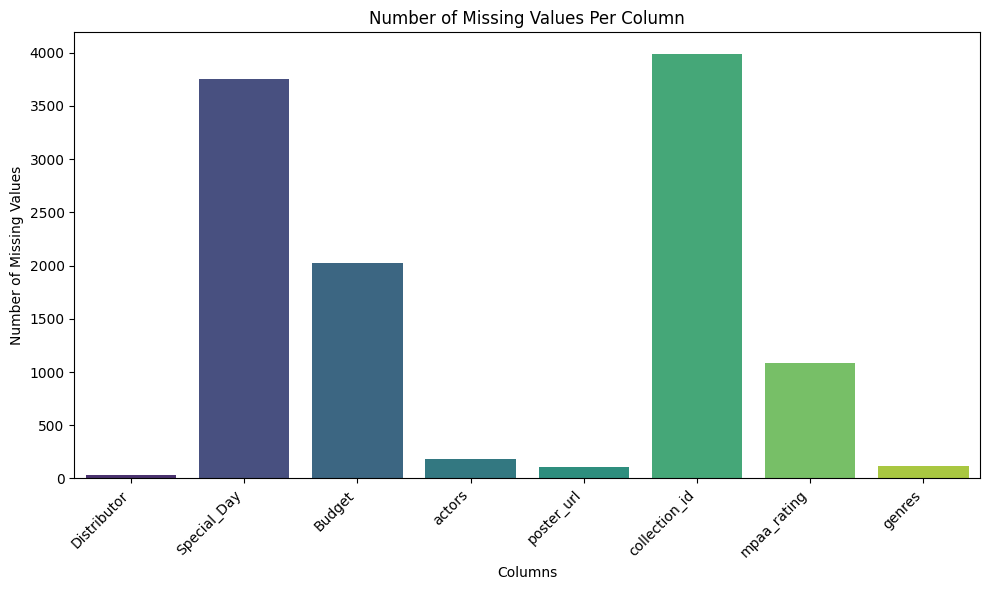

In [5]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values, hue=missing_values.index, palette='viridis', legend=False)
    plt.title('Number of Missing Values Per Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the DataFrame.")

Maximum null values come from **collection ID** column, since most of the movies are not sequels or part of any franchise.

The **special day** column has second most null values becayse this column only shows major US holidays out of all the days in a year.

The other missing metrics may belong to small budget films with no proper documentation. All null values are dealt with in Cleaning section before proceeding to Modeling.

## Financial Analysis

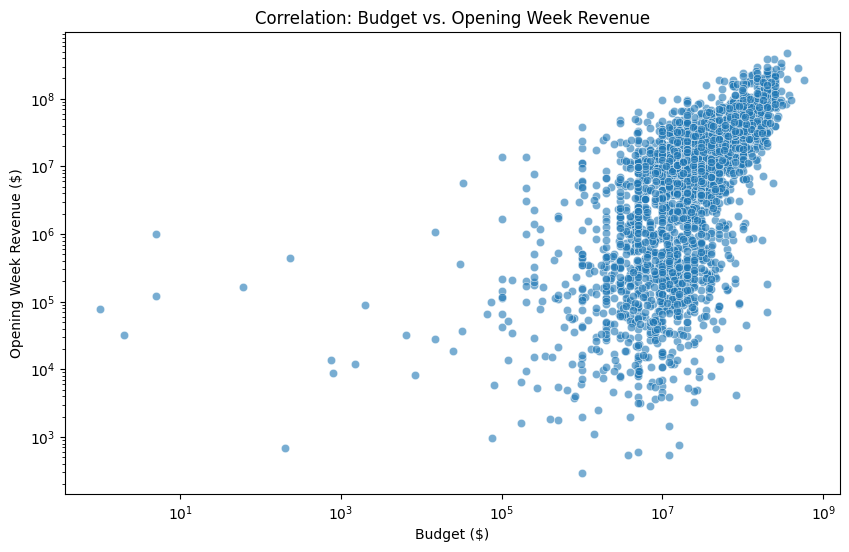

In [6]:
# Revenue vs. Budget Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Budget', y='Opening_Week_Revenue', alpha=0.6)
plt.title('Correlation: Budget vs. Opening Week Revenue')
plt.xlabel('Budget ($)')
plt.ylabel('Opening Week Revenue ($)')
plt.xscale('log') # Log scale helps visualize the wide range of values
plt.yscale('log')
plt.show()

## Trend Analysis

In [7]:
# Ensuring datetime format before extraction
df['Release_Date'] = pd.to_datetime(df['Release_Date'])

# Extract Year, Month, and Day of Week
df['Year'] = df['Release_Date'].dt.year
df['Month'] = df['Release_Date'].dt.month_name()
df['Day_of_Week'] = df['Release_Date'].dt.day_name()

# Define explicit order for months and days
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

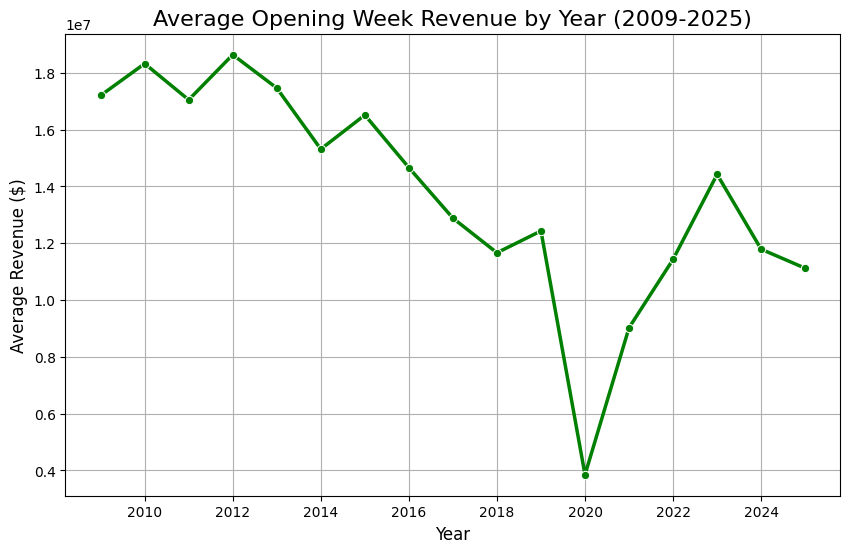

In [8]:
# --- Yearly Trend Analysis ---

# 1. Aggregate average revenue by Year
yearly_trend = df.groupby('Year')['Opening_Week_Revenue'].mean().reset_index()

# 2. Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_trend, x='Year', y='Opening_Week_Revenue', marker='o', linewidth=2.5, color='green')

# Labels and Title
plt.title('Average Opening Week Revenue by Year (2009-2025)', fontsize=16)
plt.ylabel('Average Revenue ($)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True)

plt.show()

A massive dip is seen in 2020 due to the COVID-19 pandemic when theaters closed and productions halted. Revenue did bounce back fairly quickly due to a few huge hits (like Avatar 2, Spider-Man: No Way Home).

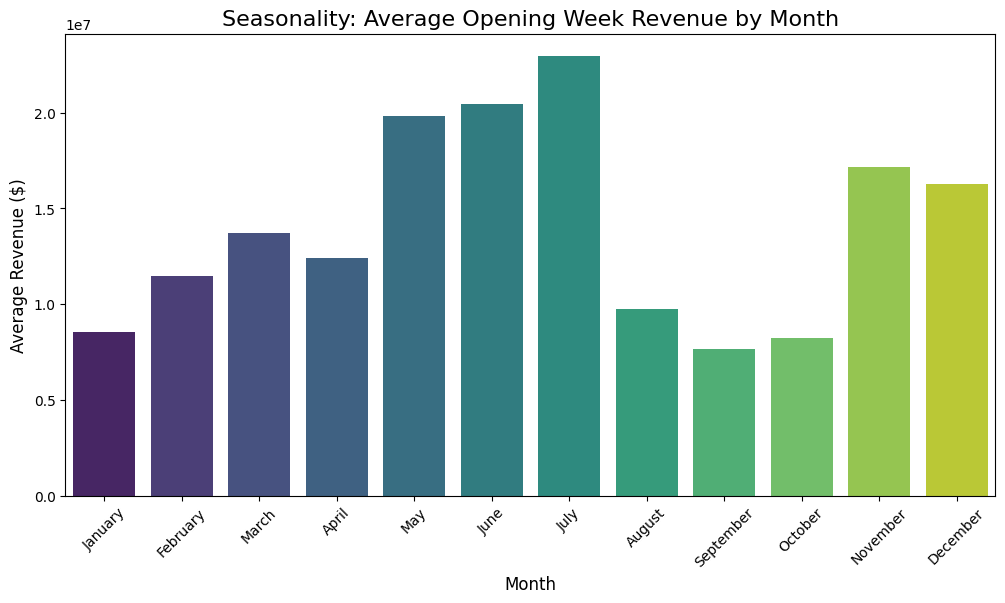

In [9]:
# --- Monthly Seasonality Analysis ---

# 2. Aggregate average revenue by Month and reindex
monthly_trend = df.groupby('Month')['Opening_Week_Revenue'].mean().reindex(month_order).reset_index()

# 3. Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_trend, x='Month', y='Opening_Week_Revenue', palette='viridis', hue='Month', legend=False)

# Labels and Title
plt.title('Seasonality: Average Opening Week Revenue by Month', fontsize=16)
plt.ylabel('Average Revenue ($)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=45) # Rotate month names for better readability

plt.show()

This highlights the "Blockbuster Seasons". July has the highest peak followed by May and June (**summer break**) and November, December (**holidays**) follow suit.

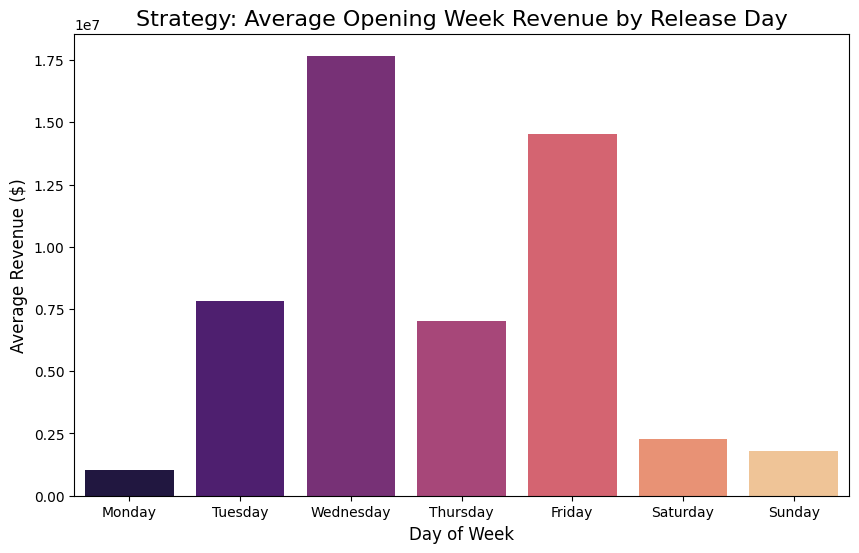

In [10]:
# --- Day of Week Analysis ---

# Aggregate average revenue by Day and reindex
daily_trend = df.groupby('Day_of_Week')['Opening_Week_Revenue'].mean().reindex(day_order).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=daily_trend, x='Day_of_Week', y='Opening_Week_Revenue', palette='magma', hue='Day_of_Week', legend=False)

# Labels and Title
plt.title('Strategy: Average Opening Week Revenue by Release Day', fontsize=16)
plt.ylabel('Average Revenue ($)', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)

plt.show()

**Wednesday releases show highest average revenue**: Studios rarely release movies then unless they are massive blockbusters that are guaranteed to draw crowds mid-week. Since almost only hit movies open on Wednesdays, the "Average" is sky-high; there are no "small" movies dragging the average down. Same may be the case with Tuesday.

**Friday is the standard release day**, so it has a high bar, but it is lower than Wednesday as it consists of both blockbusters and lower-grossing movies that *dilute* the average.

The rest are **dump days**, and these slots are used for limited releases, contractual obligation (screening before moving on to streaming platforms) and re-releases.


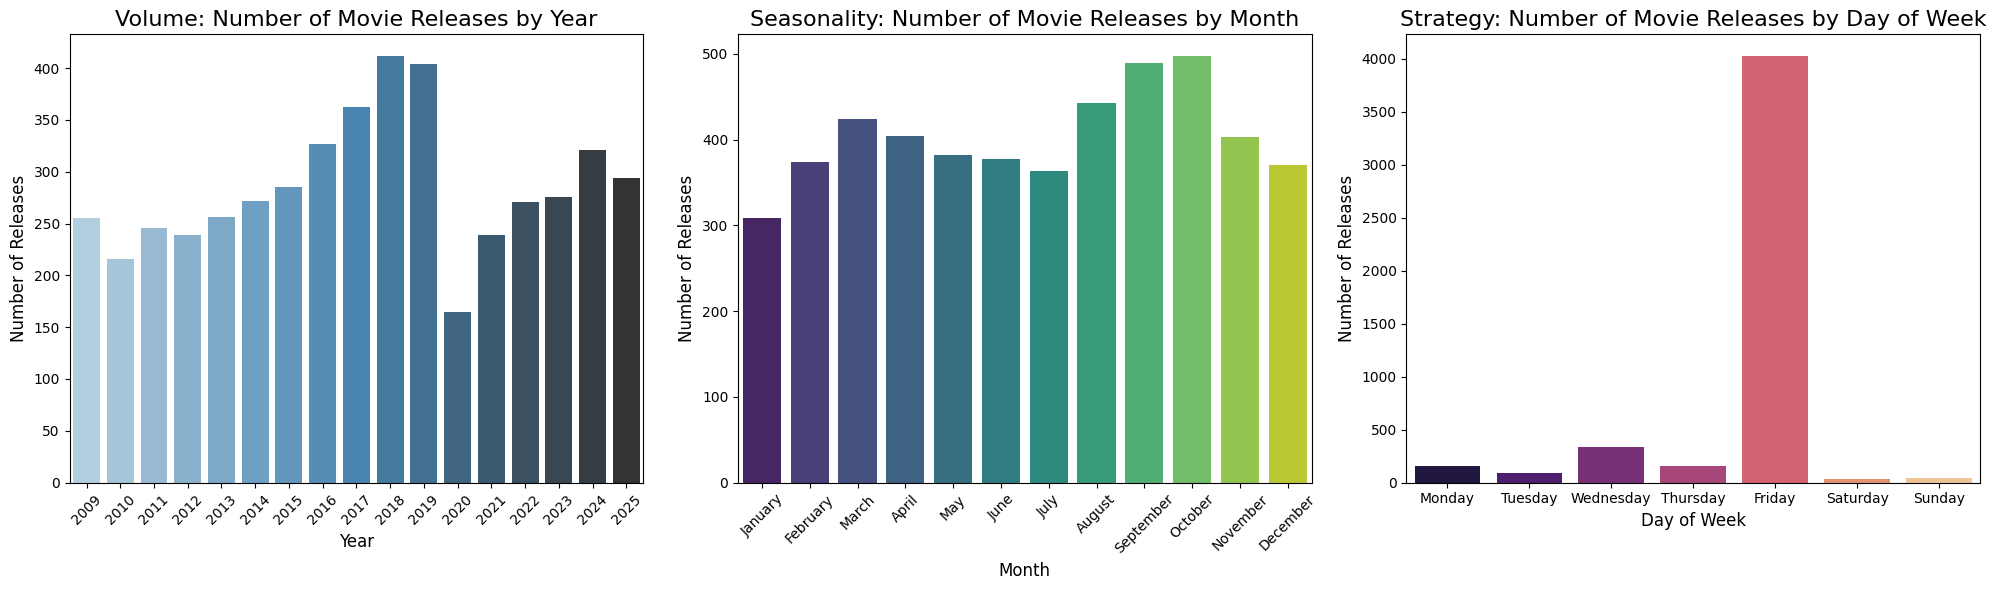

In [11]:
# We count the unique movie IDs ('tconst') to get the number of releases
yearly_counts = df.groupby('Year')['tconst'].count().reset_index().rename(columns={'tconst': 'No_of_Releases'})
monthly_counts = df.groupby('Month')['tconst'].count().reindex(month_order).reset_index().rename(columns={'tconst': 'No_of_Releases'})
daily_counts = df.groupby('Day_of_Week')['tconst'].count().reindex(day_order).reset_index().rename(columns={'tconst': 'No_of_Releases'})

# 4. Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Yearly Release Volume ---
sns.barplot(data=yearly_counts, x='Year', y='No_of_Releases', ax=axes[0], palette='Blues_d', hue='Year', legend=False)
axes[0].set_title('Volume: Number of Movie Releases by Year', fontsize=16)
axes[0].set_ylabel('Number of Releases', fontsize=12)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# --- Plot 2: Monthly Release Volume ---
sns.barplot(data=monthly_counts, x='Month', y='No_of_Releases', ax=axes[1], palette='viridis', order=month_order, hue='Month', legend=False)
axes[1].set_title('Seasonality: Number of Movie Releases by Month', fontsize=16)
axes[1].set_ylabel('Number of Releases', fontsize=12)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# --- Plot 3: Day of Week Release Volume ---
sns.barplot(data=daily_counts, x='Day_of_Week', y='No_of_Releases', ax=axes[2], palette='magma', order=day_order, hue='Day_of_Week', legend=False)
axes[2].set_title('Strategy: Number of Movie Releases by Day of Week', fontsize=16)
axes[2].set_ylabel('Number of Releases', fontsize=12)
axes[2].set_xlabel('Day of Week', fontsize=12)

plt.tight_layout()
plt.show()

###Findings


*  Friday significantly dominates all other days in volume of releases, as studios try to maximize the opening **weekend** in the US and would garner maximum crowd at the theaters.
    *   Wednesday has the second highest volume as studios release massive blockbusters (to get a 5-day opening) or before major holidays (like Thanksgiving or July 4th) to capture the holiday crowd early.

*  The **seasonality** pattern is interesting. While November and December have high volume of releases owing to the holiday season, "dump months" from August to October also have maximum releases with October having the highest. This may be due to a lot of smaller budget movies releasing within this period.
    * High-revenue months like May and July do not have the highest number of releases because when a "tentpole" movie is released, smaller movies avoid that date to not get crushed.
    * Aside from the holidays, no. of releases are higher during November and December to also have a better chance of winning the Oscar as the movies remain fresh in the minds of Academy voters.

* Movie releases show a significant decline during 2020, owing to **COVID-19 outbreak**. Unlike revenue, the volume is recovering slower. This indicates that studios are becoming more selective, releasing fewer movies theatrically and sending more mid-budget films directly to streaming services.

## Genre Analysis

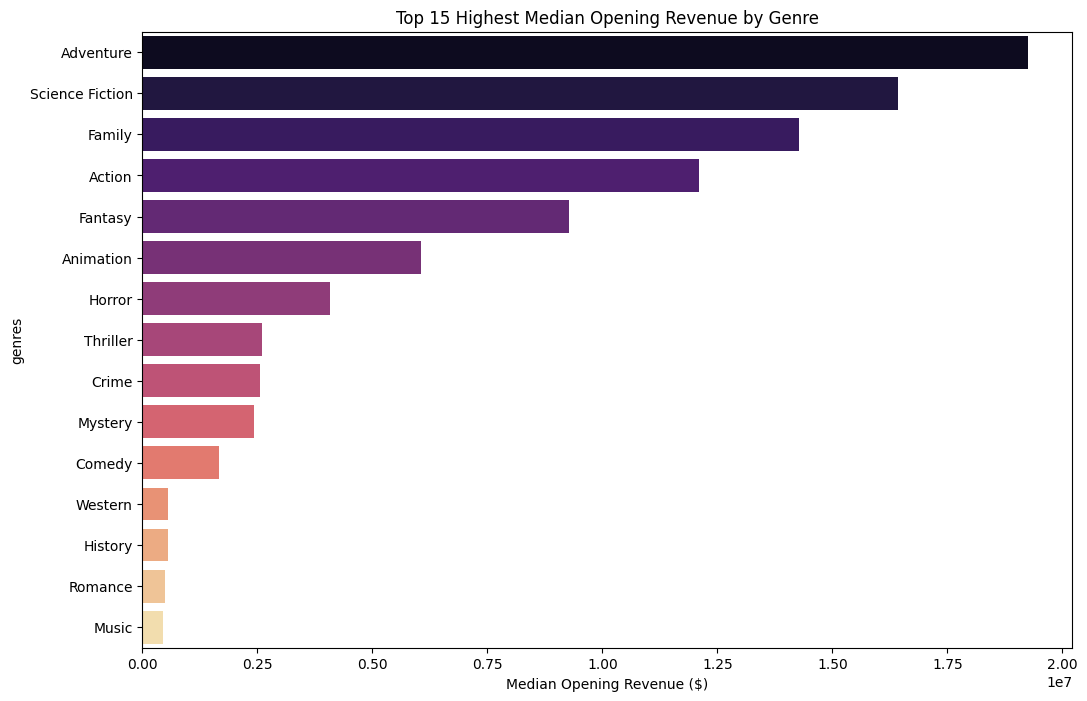

In [12]:
# Split the genre strings into lists and 'explode' them into separate rows
df_genres = df.assign(genres=df['genres'].str.split(',')).explode('genres')

# Most Profitable Genres
genre_revenue = df_genres.groupby('genres')['Opening_Week_Revenue'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=genre_revenue.values, y=genre_revenue.index, palette='magma', hue=genre_revenue.index, legend=False)
plt.title('Top 15 Highest Median Opening Revenue by Genre')
plt.xlabel('Median Opening Revenue ($)')
plt.show()

###Finding
Adventure has the highest median revenue earned during opening week followed by Sci-Fi. This is an important insight, as the Avatar franchise falls in both of these categories. So it may prelude to the box office success of the upcoming movie.

##Theater vs. Revenue

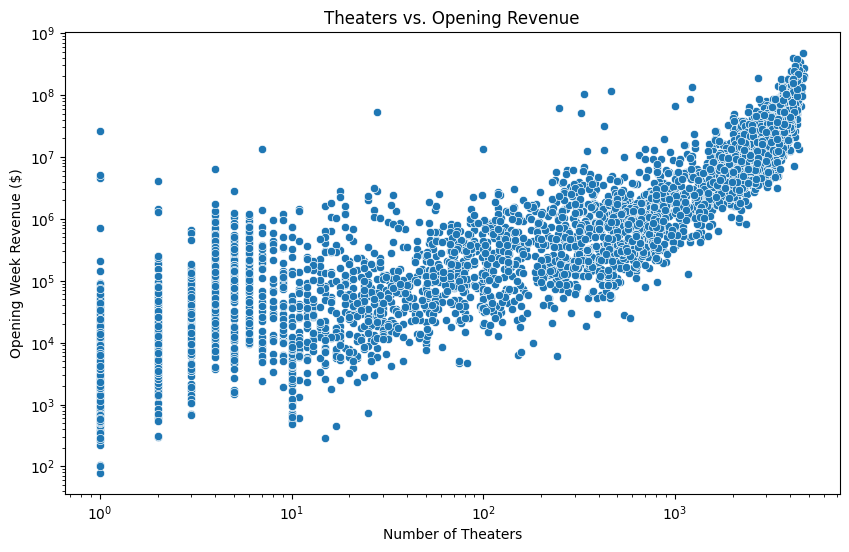

In [13]:
# Clean Theaters: Remove commas, convert to numeric, and fill NaNs
temp_theaters = df['Theaters'].str.replace(',', '', regex=True)
df['Theaters'] = pd.to_numeric(temp_theaters, errors='coerce').fillna(0).astype(int)

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Theaters', y='Opening_Week_Revenue')
plt.title('Theaters vs. Opening Revenue')
plt.xlabel('Number of Theaters')
plt.ylabel('Opening Week Revenue ($)')
plt.xscale('log') # Log scale helps visualize the wide range of values
plt.yscale('log')
plt.show()

###Finding:
As the number of theaters increases (moving right on the X-axis), the opening week revenue generally increases (moving up on the Y-axis). The relationship is likely non-linear as the axes are on logarithmic scale.

##Distributor Performance

In [14]:
num_unique_distributors = df['Distributor'].nunique()
print(f"Number of unique distributors: {num_unique_distributors}")

Number of unique distributors: 387


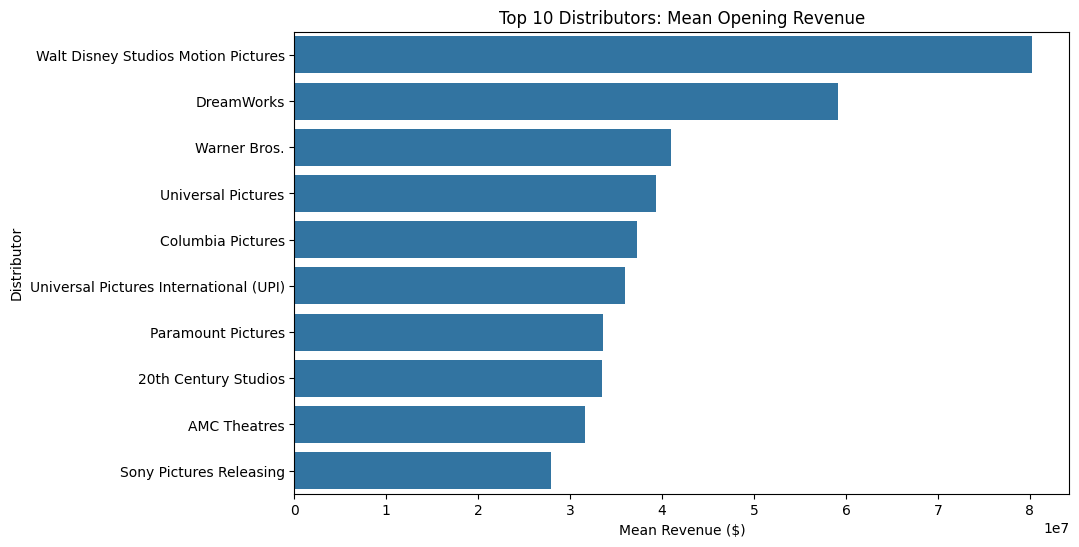

In [15]:
# Changing pre-acquisition name of 20th Century Studios
df['Distributor'] = df['Distributor'].str.replace('Twentieth Century Fox', '20th Century Studios', regex=False)

# Pivot: Mean revenue by distributor (top 10)
dist_pivot = df.pivot_table(values='Opening_Week_Revenue', index='Distributor', aggfunc='mean').sort_values('Opening_Week_Revenue', ascending=False)
top_dist = dist_pivot.head(10)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_dist.reset_index(), x='Opening_Week_Revenue', y='Distributor')
plt.title('Top 10 Distributors: Mean Opening Revenue')
plt.xlabel('Mean Revenue ($)')
plt.show()


###Findings

A few distributors dominate the industry, with Walt Disney exceeding the rest by a huge margin. Nonetheless, our distributor of interest, 20th Century Fox, which handles Avatar theatrical release is thriving in the top 4%.

##Correlation among the Target & Quant Features

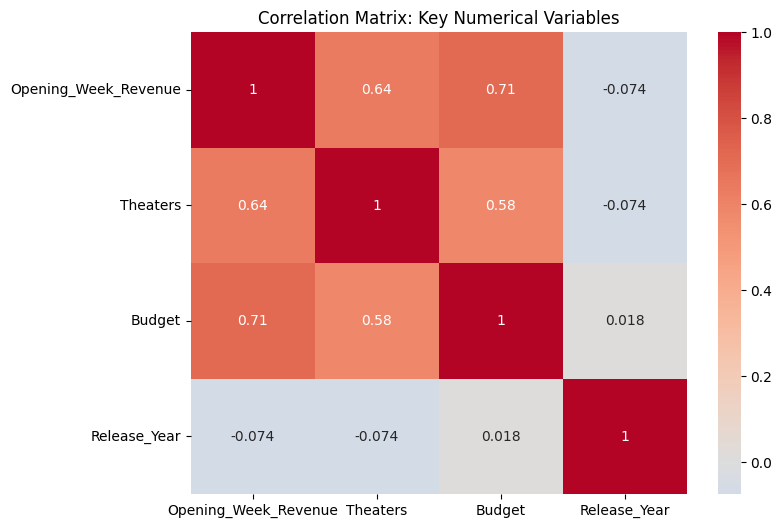

In [16]:
# Correlation matrix for key numerical vars
num_cols = ['Opening_Week_Revenue', 'Theaters', 'Budget', 'Release_Year']
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Key Numerical Variables')
plt.show()

#Data Cleaning

`Theaters` was cleaned while performing EDA.

Now, I fill the empty `Special Day` cells with 'None'.

I remove the `poster_url` column as it is not usable for prediction and will create unnecessary dimensionality.

I also remove the records with null values in `Budget` column as it seems to be the most significant quantifiable metric for our prediction.

`runtimeMinutes` is converted from object to integer type.

In [17]:
df[df['directors'] == 'nm0000116']

,tconst,Release,Opening_Week_Revenue,Release_Date,Theaters,Release_Year,Distributor,runtimeMinutes,directors,Special_Day,...,actors,cast_count,poster_url,is_sequel,collection_id,mpaa_rating,genres,Year,Month,Day_of_Week
250,tt0499549,Avatar,137094051,2009-12-18,3452,2009,20th Century Studios,162,nm0000116,Christmas Day,...,"Sam Worthington, Zoe Saldaña, Sigourney Weaver...",67,https://image.tmdb.org/t/p/original/gKY6q7SjCk...,1,87096.0,PG-13,"Action,Adventure,Fantasy,Science Fiction",2009,December,Friday
3941,tt1630029,Avatar: The Way of Water,197681686,2022-12-16,4202,2022,20th Century Studios,192,nm0000116,NaN,...,"Sam Worthington, Zoe Saldaña, Sigourney Weaver...",57,https://image.tmdb.org/t/p/original/t6HIqrRAcl...,1,87096.0,PG-13,"Action,Adventure,Science Fiction",2022,December,Friday


In [18]:
# Filling special_day column
df['Special_Day'] = df['Special_Day'].fillna('None')
print(df['Special_Day'].isnull().sum())

0


In [19]:
# Dropping poster_url
df = df.drop(columns=['poster_url'])

In [20]:
# Removing records with null budget
df = df.dropna(subset=['Budget'])
print(f"DataFrame shape after removing rows with missing budget: {df.shape}")

DataFrame shape after removing rows with missing budget: (2811, 20)


In [21]:
# Formating Runtime data type
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce').fillna(0).astype(int)
print(df['runtimeMinutes'].dtype)

int64


###Cleaning Distributor column

In [22]:
# Checking unique distributor values
df['Distributor'].unique()

array(['Paramount Vantage', '20th Century Studios', 'Universal Pictures',
       'Sony Pictures Releasing', 'DreamWorks', 'Warner Bros.',
       'Lionsgate', 'Third Rail Releasing', 'Screen Gems', 'Adlabs Films',
       'Summit Entertainment', 'The Weinstein Company', 'Focus Features',
       'Walt Disney Studios Motion Pictures', 'Fox Searchlight Pictures',
       'Overture Films', 'Anchor Bay Films', 'Miramax',
       'Roadside Attractions', 'Senator Distribution',
       'Paramount Pictures', 'American Zoetrope', 'Freestyle Releasing',
       'TriStar Pictures', 'UTV Motion Pictures', 'Dimension Films',
       'Image Entertainment', 'Apparition', 'Metro-Goldwyn-Mayer (MGM)',
       'Vivendi Entertainment', '-', 'Reliance Big Pictures',
       'The Samuel Goldwyn Company', 'CBS Films', 'GKIDS',
       'IndustryWorks Pictures', 'Truly Indie', 'Music Box Films',
       'Four of a Kind Productions', 'Rogue Pictures', 'Relativity Media',
       'Newmarket Films', 'China Lion Film Distrib

In [23]:
display(df[df['Distributor'].isnull()])
display(df[df['Distributor'].isnull()].shape)

,tconst,Release,Opening_Week_Revenue,Release_Date,Theaters,Release_Year,Distributor,runtimeMinutes,directors,Special_Day,Budget,actors,cast_count,is_sequel,collection_id,mpaa_rating,genres,Year,Month,Day_of_Week
4041,tt22444570,Ponniyin Selvan: Part Two,3813000,2023-04-28,600,2023,NaN,164,"nm0711745,nm7676450",None,29500000.0,"Vikram, Aishwarya Rai Bachchan, Ravi Mohan, Ka...",65,1,858086.0,NaN,"Action,Adventure,History,Drama",2023,April,Friday
4055,tt6528290,Knights of the Zodiac,760071,2023-05-12,588,2023,NaN,112,nm1313617,None,60000000.0,"Mackenyu, Madison Iseman, Diego Tinoco, Mark D...",15,0,NaN,PG-13,"Fantasy,Action,Adventure,Science Fiction",2023,May,Friday
4201,tt13751694,Animal,9272968,2023-12-01,698,2023,NaN,204,nm9227039,None,13000000.0,"Ranbir Kapoor, Rashmika Mandanna, Anil Kapoor,...",158,1,1214005.0,R,"Action,Crime,Drama",2023,December,Friday
4219,tt13927994,Salaar,7570050,2023-12-22,802,2023,NaN,175,nm6073824,Christmas Day,34000000.0,"Prabhas, Prithviraj Sukumaran, Shruti Haasan, ...",34,1,1213248.0,NaN,"Action,Crime,Drama",2023,December,Friday
4252,tt30970235,Article 370,480697,2024-02-23,161,2024,NaN,158,nm8915138,None,2413068.0,"Yami Gautam, Priyamani, Skand Thakur, Vaibhav ...",18,0,NaN,NaN,"Action,Thriller,Drama",2024,February,Friday
4388,tt27395353,50 km/h,543,2024-07-19,10,2024,NaN,110,nm0209948,None,3750000.0,"Fabio De Luigi, Stefano Accorsi, Elisa Di Eusa...",12,0,NaN,NaN,Comedy,2024,July,Friday
4416,tt22375054,Strange Darling,1844504,2024-08-23,1135,2024,NaN,97,nm2356768,None,4000000.0,"Willa Fitzgerald, Kyle Gallner, Madisen Beaty,...",16,0,NaN,R,"Horror,Thriller",2024,August,Friday
4485,tt26932223,Bhool Bhulaiyaa 3,2230000,2024-11-01,754,2024,NaN,158,nm0063357,None,17600000.0,"Kartik Aaryan, Vidya Balan, Madhuri Dixit, Tri...",22,1,977824.0,NaN,"Horror,Comedy",2024,November,Friday


(8, 20)

In [24]:
display(df[df['Distributor'] == '-'])
display(df[df['Distributor'] == '-'].shape[0])

,tconst,Release,Opening_Week_Revenue,Release_Date,Theaters,Release_Year,Distributor,runtimeMinutes,directors,Special_Day,Budget,actors,cast_count,is_sequel,collection_id,mpaa_rating,genres,Year,Month,Day_of_Week
236,tt1532957,Paa,199228,2009-12-04,67,2009,-,133,nm2669564,None,3250000.0,"Amitabh Bachchan, Abhishek Bachchan, Vidya Bal...",10,0,NaN,NaN,"Drama,Family",2009,December,Friday
363,tt1587729,71: Into the Fire,115927,2010-07-30,20,2010,-,120,nm0497565,None,10400000.0,"Kwon Sang-woo, T.O.P, Kim Seung-woo, Cha Seung...",22,0,NaN,NaN,War,2010,July,Friday
375,tt1024770,The People I've Slept With,7700,2010-08-13,1,2010,-,89,nm0004250,None,3000000.0,"Karin Anna Cheung, Wilson Cruz, Archie Kao, Ly...",16,0,NaN,NR,"Comedy,Romance",2010,August,Friday
1930,tt5071886,Kabali,3903095,2016-07-21,229,2016,-,153,nm3163794,None,18700000.0,"Rajinikanth, Radhika Apte, Sai Dhanshika, Wins...",28,0,NaN,NaN,"Action,Crime,Drama",2016,July,Thursday
2041,tt5980232,Kaashmora,327929,2016-10-28,70,2016,-,163,nm4403137,None,8900000.0,"Karthi, Nayanthara, Sri Divya, Vivek, Jangiri ...",18,0,NaN,NaN,"Fantasy,Horror,Comedy",2016,October,Friday
3777,tt13645322,F3: Fun and Frustration,1195000,2022-05-27,400,2022,-,148,nm3902889,Memorial Day,7000000.0,"Venkatesh, Varun Tej, Tamannaah Bhatia, Mehree...",32,1,990537.0,NaN,"Comedy,Romance,Family",2022,May,Friday
3982,tt15516726,Selfiee,260499,2023-02-24,308,2023,-,148,nm3262433,None,10000000.0,"Akshay Kumar, Emraan Hashmi, Nushrratt Bharucc...",21,0,NaN,NR,"Comedy,Drama",2023,February,Friday
4387,tt24517830,Bad Newz,1069000,2024-07-19,477,2024,-,142,nm2945270,None,9600000.0,"Vicky Kaushal, Triptii Dimri, Ammy Virk, Neha ...",21,0,NaN,NaN,"Comedy,Romance,Drama",2024,July,Friday
4490,tt11976134,Singham Again,2190000,2024-11-01,749,2024,-,144,nm1460159,None,41100000.0,"Ajay Devgn, Akshay Kumar, Ranveer Singh, Tiger...",78,1,286951.0,NaN,"Action,Drama,Thriller,Crime",2024,November,Friday
4607,tt32461003,The Last Supper,3990434,2025-03-14,1575,2025,-,114,nm0096332,None,8000000.0,"Jamie Ward, James Oliver Wheatley, Charlie Mac...",26,0,NaN,PG-13,"Drama,History",2025,March,Friday


12

It turns out there are movies with '-' as distributor. Upon manual inspection, I confirmed that these movies have multiple distributors. This is no different than having Null value as it adds no merit to the dataset. Additionally, most of these are foreign films which may not be relevant for our prediction. So, records with empty and '-' values in this column are dropped.

In [25]:
df = df.dropna(subset=['Distributor'])
df = df[df['Distributor'] != '-']
print(f"DataFrame shape after removing rows with null or '-' distributor: {df.shape}")

DataFrame shape after removing rows with null or '-' distributor: (2791, 20)


### Removing null MPAA rating values

In [26]:
display(df[df['mpaa_rating'].isnull()])
display(df[df['mpaa_rating'].isnull()].shape)

,tconst,Release,Opening_Week_Revenue,Release_Date,Theaters,Release_Year,Distributor,runtimeMinutes,directors,Special_Day,Budget,actors,cast_count,is_sequel,collection_id,mpaa_rating,genres,Year,Month,Day_of_Week
8,tt1091229,CC2C,744219,2009-01-16,130,2009,Warner Bros.,154,nm0012541,Martin Luther King Jr. Day,12000000.0,"Akshay Kumar, Deepika Padukone, Mithun Chakrab...",9,0,NaN,NaN,"Action,Adventure,Comedy",2009,January,Friday
20,tt0886539,Luck by Chance,247400,2009-01-30,57,2009,Adlabs Films,156,nm0015295,None,2300000.0,"Farhan Akhtar, Konkona Sen Sharma, Dimple Kapa...",36,0,NaN,NaN,"Romance,Drama,Comedy",2009,January,Friday
102,tt1324078,Kal Kissne Dekha,18532,2009-06-12,18,2009,Adlabs Films,134,nm1018908,None,24625.0,"Jacky Bhagnani, Vaishali Desai, Rishi Kapoor, ...",10,0,NaN,NaN,"Drama,Comedy,Romance",2009,June,Friday
141,tt1274295,Kaminey,852298,2009-08-14,85,2009,UTV Motion Pictures,130,nm0080235,None,9000000.0,"Shahid Kapoor, Priyanka Chopra Jonas, Amole Gu...",12,0,NaN,NaN,"Action,Crime,Drama",2009,August,Friday
193,tt1324059,Wake Up Sid,415222,2009-10-02,79,2009,UTV Motion Pictures,138,nm2209781,None,3000000.0,"Ranbir Kapoor, Konkona Sen Sharma, Rahul Khann...",10,0,NaN,NaN,"Comedy,Drama,Romance",2009,October,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,tt13705368,Tuesday,32098,2024-06-07,2,2024,A24,0,nm8270807,None,6500.0,"Maddie Scanlan, Madison Rotolo, Elijahwan Butl...",10,0,NaN,NaN,"Drama,Comedy,Romance",2024,June,Friday
4355,tt28354262,Jesus,410292,2024-06-20,323,2024,Iconic Events Releasing,147,nm9541024,None,4800000.0,"Gideon Firl, Miles Barbee, Ryan Schlecht, Chri...",17,0,NaN,NaN,"Drama,History",2024,June,Thursday
4393,tt26233598,Raayan,377000,2024-07-26,133,2024,Prime Media Pictures,145,nm1333687,None,11900000.0,"Dhanush, Dushara Vijayan, Sundeep Kishan, Kali...",24,0,NaN,NaN,"Action,Drama,Thriller",2024,July,Friday
4574,tt26745321,Armand,25950,2025-02-07,2,2025,IFC Films,118,nm6014531,None,1508482.0,"Renate Reinsve, Ellen Dorrit Petersen, Endre H...",9,0,NaN,NaN,"Drama,Thriller",2025,February,Friday


(166, 20)

Most of these are foreign films or arthouse movies with very small budget. These are not very relevant for our prediction, so I drop these rows.

In [27]:
df = df.dropna(subset=['mpaa_rating'])

#Feature Engineering

### Special Holidays (Binary Flag)

I turn the Special_Day column into a simple 1 (Yes) or 0 (No) flag, which will be easier for the model to interpret than specific holiday names.

In [28]:
df['Special_Day'] = df['Special_Day'].apply(lambda x: 0 if x == 'None' else 1)

### Lead Actors

I extract the first two names from each row of the actors column as the names are arrranged in order of importance i.e., the first ones are lead characters. Then I remove the existing actors column as so many names are unnecessary would reduce model accuracy.

In [29]:
# Function to extract the first two actor names
def get_first_two_actors(actors_str):
    if pd.isna(actors_str):
        return np.nan
    actor_list = [actor.strip() for actor in actors_str.split(',') if actor.strip()]
    if len(actor_list) >= 2:
        return ', '.join(actor_list[:2])
    elif len(actor_list) == 1:
        return actor_list[0]
    else:
        return np.nan

# Apply the function to create a new 'top_actors' column
df['top_actors'] = df['actors'].apply(get_first_two_actors)

# Drop the actors column; very populated
df = df.drop(columns=['actors'])

##Distributor Bins

Between quantity or count of movies produced and financial power (budget), I incorporated both to find the relative market share of each distributor and accordingly assign them to the 3 bins: big, medium, and small.

In [30]:
# 1. Calculate Total Budget per Distributor (The "Market Footprint")
#    We sum the budget of all movies released by each distributor
dist_market_stats = df.groupby('Distributor')['Budget'].sum().reset_index()
dist_market_stats.rename(columns={'Budget': 'Total_Invested_Budget'}, inplace=True)

# 2. Calculate Market Share (%)
#    Formula: Distributor's Total Budget / Industry Total Budget
industry_total_budget = dist_market_stats['Total_Invested_Budget'].sum()
dist_market_stats['Market_Share_Percent'] = (dist_market_stats['Total_Invested_Budget'] / industry_total_budget) * 100

# 3. Define Tiers based on Market Share

#    - Top 10 studios control ~80% of the market (Dominant)
#    - The next ~50 studios control ~15% (Established)
#    - The remaining hundreds control the last 5% (Niche)

def get_market_tier(share_percent):
    if share_percent >= 1.0:       # Controls >1% of the entire industry money (Disney, WB, Universal)
        return 'Big'
    elif share_percent >= 0.1:     # Controls 0.1% - 1% (A24, STX, Open Road)
        return 'Medium'
    else:                          # Controls <0.1% (Small Indies)
        return 'Small'

dist_market_stats['Distributor_Tier'] = dist_market_stats['Market_Share_Percent'].apply(get_market_tier)

# 4. Merge this back into your main dataframe
df = df.merge(dist_market_stats[['Distributor', 'Market_Share_Percent', 'Distributor_Tier']], on='Distributor', how='left')

# See where Avatar's distributor falls
print("Avatar's Distributor Status:")
print(df[df['Release'].str.contains("Avatar")][['Distributor', 'Distributor_Tier', 'Market_Share_Percent']].drop_duplicates())

# See the top players by Market Share
print("\nTop 5 Distributors by Market Share:")
print(df[['Distributor', 'Distributor_Tier', 'Market_Share_Percent']].drop_duplicates().sort_values('Market_Share_Percent', ascending=False).head(5))

Avatar's Distributor Status:
              Distributor Distributor_Tier  Market_Share_Percent
171  20th Century Studios              Big             10.113726

Top 5 Distributors by Market Share:
                            Distributor Distributor_Tier  Market_Share_Percent
19  Walt Disney Studios Motion Pictures              Big             17.608081
7                          Warner Bros.              Big             16.734253
3                    Universal Pictures              Big             11.472238
2                  20th Century Studios              Big             10.113726
4               Sony Pictures Releasing              Big              8.724905


## Bankability of Directors

For this computation a few factors were considered:


*   Only past data considered for every record to prevent data leakage
*   Budget, revenue, no. of movies, distributor imputed for the score
*   "Debut" directors (i.e., directors with no prior movies in the dataset) given different scores depending on the budget and distributor for their first film



In [31]:
def extract_directors(director_string):
    """
    Extract list of directors from string.
    Handles formats like "Director1, Director2" or single director
    """
    if pd.isna(director_string):
        return []
    return [d.strip() for d in str(director_string).split(',')]

# Explode directors so each director-movie pair gets a row
df_exploded = df.copy()
df_exploded['director_list'] = df_exploded['directors'].apply(extract_directors)
df_exploded = df_exploded.explode('director_list')
df_exploded = df_exploded[df_exploded['director_list'].notna() & (df_exploded['director_list'] != '')]
df_exploded.rename(columns={'director_list': 'director'}, inplace=True)

# Create distributor tier scores
distributor_scores = {
    'Big': 100,
    'Medium': 60,
    'Small': 30
}

df_exploded['distributor_score'] = df_exploded['Distributor_Tier'].map(distributor_scores).fillna(30)

# Calculate director-level metrics
director_stats = df_exploded.groupby('director').agg({
    'Budget': ['count', 'median', 'mean', 'max'],
    'Opening_Week_Revenue': ['sum', 'mean', 'median'],
    'distributor_score': 'mean',
    'Release_Year': ['min', 'max']
}).reset_index()

# Flatten column names
director_stats.columns = [
    'director', 'movie_count', 'median_budget', 'mean_budget', 'max_budget',
    'total_revenue', 'mean_revenue', 'median_revenue',
    'avg_distributor_score', 'first_year', 'last_year'
]

# Calculate career span
director_stats['career_span'] = director_stats['last_year'] - director_stats['first_year'] + 1

# ========================================

# Bankability Components

# Component 1: Track Record Score (0-100); Based on number of movies and career span

director_stats['track_record_score'] = (
    # Movies count (logarithmic to prevent huge differences)
    30 * np.log1p(director_stats['movie_count']) / np.log1p(director_stats['movie_count'].max()) +
    # Career span (capped at 20 years for max score)
    20 * np.minimum(director_stats['career_span'] / 20, 1)
)

# Component 2: Budget Access Score (0-100); Higher budgets = more industry trust
director_stats['budget_access_score'] = (
    director_stats['median_budget'].fillna(0) / director_stats['median_budget'].max()
) * 100

# Component 3: Revenue Performance Score (0-100); Based on average revenue generated
director_stats['revenue_score'] = (
    director_stats['mean_revenue'].fillna(0) / director_stats['mean_revenue'].max()
) * 100

# Component 4: Distributor Quality Score (0-100)
# Already calculated as avg_distributor_score

# Component 5: Consistency Score (0-100); Lower coefficient of variation = more consistent
def calculate_consistency(director_name):
    director_revenues = df_exploded[df_exploded['director'] == director_name]['Opening_Week_Revenue']
    if len(director_revenues) <= 1:
        return 50  # Neutral score for single-movie directors
    cv = director_revenues.std() / director_revenues.mean() if director_revenues.mean() > 0 else 0
    # Lower CV = higher consistency score (inverted and normalized)
    return max(0, 100 - (cv * 20))  # Scale and invert

director_stats['consistency_score'] = director_stats['director'].apply(calculate_consistency)

# ========================================
# Calculate Final Bankability Score

# Weighted combination of all components
weights = {
    'track_record': 0.20,      # 20% - Experience matters
    'budget_access': 0.25,     # 25% - Industry trust is crucial
    'revenue': 0.25,           # 25% - Proven box office success
    'distributor': 0.20,       # 20% - Working with top distributors
    'consistency': 0.10        # 10% - Reliability
}

director_stats['bankability_score'] = (
    weights['track_record'] * director_stats['track_record_score'] +
    weights['budget_access'] * director_stats['budget_access_score'] +
    weights['revenue'] * director_stats['revenue_score'] +
    weights['distributor'] * director_stats['avg_distributor_score'] +
    weights['consistency'] * director_stats['consistency_score']
)

# Normalize to 0-100 scale
director_stats['bankability_score'] = (
    director_stats['bankability_score'] / director_stats['bankability_score'].max()
) * 100

# ========================================
# Create Bankability Tiers

def assign_bankability_tier(score):
    if score >= 80:
        return 'A-List'
    elif score >= 60:
        return 'Established'
    elif score >= 40:
        return 'Rising'
    elif score >= 20:
        return 'Emerging'
    else:
        return 'Debut'

director_stats['bankability_tier'] = director_stats['bankability_score'].apply(assign_bankability_tier)

# ========================================
# Handle Debut Directors Specially


# For debut directors (single movie), use budget & distributor as differentiators
debut_mask = director_stats['movie_count'] == 1

# Recalculate debut directors' scores based on their first film's backing
director_stats.loc[debut_mask, 'bankability_score'] = (
    0.5 * director_stats.loc[debut_mask, 'budget_access_score'] +
    0.5 * director_stats.loc[debut_mask, 'avg_distributor_score']
)

# Re-normalize debut scores to 0-40 range (they can't be A-list yet)
if debut_mask.sum() > 0:
    debut_scores = director_stats.loc[debut_mask, 'bankability_score']
    director_stats.loc[debut_mask, 'bankability_score'] = (
        (debut_scores / debut_scores.max()) * 40
    ) if debut_scores.max() > 0 else 20

# Reassign tiers after debut adjustment
director_stats['bankability_tier'] = director_stats['bankability_score'].apply(assign_bankability_tier)

# ========================================
# Merge Back to Original DataFrame


# Create mapping dictionary
bankability_mapping = dict(zip(director_stats['director'], director_stats['bankability_score']))
tier_mapping = dict(zip(director_stats['director'], director_stats['bankability_tier']))

# For movies with multiple directors, take the maximum bankability
def get_max_bankability(director_string):
    directors = extract_directors(director_string)
    if not directors:
        return np.nan
    scores = [bankability_mapping.get(d, 0) for d in directors]
    return max(scores) if scores else np.nan

def get_primary_tier(director_string):
    directors = extract_directors(director_string)
    if not directors:
        return 'Unknown'
    # Get tier of most bankable director
    scores = [(d, bankability_mapping.get(d, 0)) for d in directors]
    top_director = max(scores, key=lambda x: x[1])[0] if scores else directors[0]
    return tier_mapping.get(top_director, 'Unknown')

df['director_bankability'] = df['directors'].apply(get_max_bankability)
df['director_tier'] = df['directors'].apply(get_primary_tier)


In [32]:
df.head()

,tconst,Release,Opening_Week_Revenue,Release_Date,Theaters,Release_Year,Distributor,runtimeMinutes,directors,Special_Day,...,mpaa_rating,genres,Year,Month,Day_of_Week,top_actors,Market_Share_Percent,Distributor_Tier,director_bankability,director_tier
0,tt1034303,Defiance,195622,2009-01-01,2,2009,Paramount Vantage,137,nm0001880,1,...,R,"Action,Drama,History,War",2009,January,Thursday,"Daniel Craig, Liev Schreiber",0.109127,Medium,39.282847,Emerging
1,tt0959337,Revolutionary Road,76319,2009-01-01,3,2009,Paramount Vantage,119,nm0005222,1,...,R,"Drama,Romance",2009,January,Thursday,"Leonardo DiCaprio, Kate Winslet",0.109127,Medium,48.892575,Rising
2,tt0901476,Bride Wars,25827125,2009-01-09,3226,2009,20th Century Studios,89,nm0935095,0,...,PG,"Comedy,Romance",2009,January,Friday,"Kate Hudson, Anne Hathaway",10.113726,Big,39.937508,Emerging
3,tt1139668,The Unborn,23239155,2009-01-09,2357,2009,Universal Pictures,88,nm0275286,0,...,PG-13,"Horror,Thriller,Mystery",2009,January,Friday,"Odette Annable, Cam Gigandet",11.472238,Big,22.366757,Emerging
4,tt1114740,Paul Blart: Mall Cop,43300198,2009-01-16,3144,2009,Sony Pictures Releasing,91,nm0139867,1,...,PG,"Action,Adventure,Comedy,Family",2009,January,Friday,"Kevin James, Keir O'Donnell",8.724905,Big,39.321990,Emerging


In [33]:
corr = df['director_bankability'].corr(df['Opening_Week_Revenue'])
print(f"Correlation: {corr:.3f}")  # If low, consider refining the score

Correlation: 0.549


There exists a moderately positive correlation between the new feature and the target, so I keep the modified feature.

## Labeling Genres

As genres are not mutually exclusive, I use Multilabel Binarizer instead of One-Hot Encoding which would create a new column for every combination of genres. MLB creates one column per unique genre.

In [34]:
# ========================================
# STEP 1: Parse Genres into Lists
# ========================================

def parse_genres(genre_string):
    """
    Convert genre string to list of genres.
    Handles formats: "Action,Drama,History" → ["Action", "Drama", "History"]
    """
    if pd.isna(genre_string):
        return []

    # Split by comma and strip whitespace
    genres = [g.strip() for g in str(genre_string).split(',')]

    # Remove empty strings
    genres = [g for g in genres if g]

    return genres

# Create a new column with genre lists
df['genre_list'] = df['genres'].apply(parse_genres)

# ========================================
# STEP 2: Apply MultiLabelBinarizer
# ========================================

# Initialize the binarizer
mlb = MultiLabelBinarizer()

# Fit and transform the genre lists
genre_encoded = mlb.fit_transform(df['genre_list'])

# Create DataFrame with genre columns
genre_df = pd.DataFrame(
    genre_encoded,
    columns=mlb.classes_,
    index=df.index
)

# Add prefix to genre columns for clarity
genre_df = genre_df.add_prefix('genre_')

# ========================================
# STEP 3: Combine with Original DataFrame
# ========================================

# Add genre columns to original dataframe
df = pd.concat([df, genre_df], axis=1)

# Drop the temporary genre_list column
df = df.drop(columns=['genre_list'])

##Franchise information

To identify franchises separately from standalone movies, I use the collection ID and label them chronologically.

In [35]:
# If 'collection_id' is not null, it is part of a franchise
df['is_franchise'] = df['collection_id'].notnull()

# We group by 'collection_id', and then count the cumulative number of items ordered by 'Release_Date'.
# We add 1 because cumcount starts at 0.
df['franchise_number'] = df.sort_values('Release_Date').groupby('collection_id').cumcount() + 1

df.loc[~df['is_franchise'], 'franchise_number'] = float('nan')
df['franchise_number'] = df['franchise_number'].fillna(0)
df['franchise_number'] = df['franchise_number'].astype(int) # converted to integer

In [36]:
df.columns

Index(['tconst', 'Release', 'Opening_Week_Revenue', 'Release_Date', 'Theaters',
       'Release_Year', 'Distributor', 'runtimeMinutes', 'directors',
       'Special_Day', 'Budget', 'cast_count', 'is_sequel', 'collection_id',
       'mpaa_rating', 'genres', 'Year', 'Month', 'Day_of_Week', 'top_actors',
       'Market_Share_Percent', 'Distributor_Tier', 'director_bankability',
       'director_tier', 'genre_Action', 'genre_Adventure', 'genre_Animation',
       'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
       'genre_Music', 'genre_Mystery', 'genre_Romance',
       'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller',
       'genre_War', 'genre_Western', 'is_franchise', 'franchise_number'],
      dtype='object')

##Binning for Pandemic Years

The COVID-19 pandemic did not just pause the film industry; it fundamentally broke and then reassembled the business model.

* Before 2020, a movie played exclusively in theaters for 90 days before it could go to DVD or streaming. During the pandemic, studios (desperate for cash) shattered this window; some movies went to streaming immediately ("Day-and-Date"), while others shortened the window to just 45 days (or even 17 days).

* The pandemic accelerated a trend where audiences stopped going to theaters for "medium" movies (comedies, rom-coms, mid-budget dramas). For nearly two years, older demographics (who drive ticket sales for dramas) stayed home due to health concerns, while younger demographics returned for horror and action movies.

Thus, to capture this irreversible shift, a new column is added to capture the timeline of the pandemic.

In [37]:
# 1. Define the Cutoff Dates
# Pandemic Start: March 2020 (Mass shutdowns began)
# Post-Pandemic Start: Jan 2022 (Industry generally considers 2022 the start of the recovery/new normal)
PANDEMIC_START = pd.to_datetime('2020-03-01')
POST_PANDEMIC_START = pd.to_datetime('2022-01-01')

# 2. Function to assign Era
def get_release_era(release_date):
    if release_date < PANDEMIC_START:
        return 'Pre_Pandemic'
    elif release_date >= POST_PANDEMIC_START:
        return 'Post_Pandemic'
    else:
        return 'Pandemic'

# 3. Apply the function
df['release_era'] = df['Release_Date'].apply(get_release_era)

# 4. Check the distribution
print("Movie counts per era:")
print(df['release_era'].value_counts())

# 5. One-Hot Encoding
# This creates columns: release_era_Pre_Pandemic, release_era_Pandemic, release_era_Post_Pandemic
df = pd.get_dummies(df, columns=['release_era'], prefix='era')


# Display result
print("\nNew columns created:")
print(df.filter(like='era_').head())

Movie counts per era:
release_era
Pre_Pandemic     1957
Post_Pandemic     542
Pandemic          126
Name: count, dtype: int64

New columns created:
   era_Pandemic  era_Post_Pandemic  era_Pre_Pandemic
0         False              False              True
1         False              False              True
2         False              False              True
3         False              False              True
4         False              False              True


#Checking for String Values

Taking a moment to check how many columns are still in string values as I will have to encode all the relevant ones into numeric data for my final feature set.

In [38]:
string_columns = []
for col in df.columns:
    if df[col].dtype == 'object':
        string_columns.append(col)

if string_columns:
    print("Columns with string values (object dtype):")
    for col in string_columns:
        print(f"- {col}")
else:
    print("No columns with 'object' dtype found.")

Columns with string values (object dtype):
- tconst
- Release
- Distributor
- directors
- mpaa_rating
- genres
- Month
- Day_of_Week
- top_actors
- Distributor_Tier
- director_tier


##Encoding for Month and Days (Cyclical Encoding)
Months and days are cyclical (January follows December, Monday follows Sunday). Standard numbers (1 and 12) are far apart mathematically, but close in reality. Using cyclical encoding (Sine and Cosine) this closeness is preserved.

In [39]:
# Map month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Map day names to numbers
day_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

# Convert to numeric
df['month_num'] = df['Month'].map(month_map)
df['day_num'] = df['Day_of_Week'].map(day_map)

# Month cyclical encoding (12 months in a cycle)
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

# Day of week cyclical encoding (7 days in a cycle)
df['day_sin'] = np.sin(2 * np.pi * df['day_num'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_num'] / 7)

df = df.drop(columns=['month_num', 'day_num', 'Month', 'Day_of_Week'])

##Encoding MPAA rating (Ordinal Encoding)
Since MPAA ratings have a clear "age restriction" order (G < PG < PG-13 < R), mapping them to numbers preserves this hierarchy.

In [40]:
# Custom mapping based on "strictness"
rating_map = {
    'G': 1,
    'PG': 2,
    'PG-13': 3,
    'R': 4,
    'NC-17': 5,
    'NR': 0
}

df['mpaa_rating_ordinal'] = df['mpaa_rating'].map(rating_map)
df = df.drop(columns=['mpaa_rating'])

##Encoding for Actors (Bankability)


In [41]:
# 1. Setup
df['Release_Date'] = pd.to_datetime(df['Release_Date'])
df['original_index'] = df.index  # Save index

# Calculate Distributor Median Revenue (Pre-compute this lookup table)
distributor_medians = df.groupby('Distributor')['Opening_Week_Revenue'].median()

# 2. Explode Actors
df_actors = df[['original_index', 'Release_Date', 'top_actors', 'Opening_Week_Revenue', 'Distributor']].copy()
df_actors = df_actors.assign(actor=df_actors['top_actors'].str.split(', ')).explode('actor')
df_actors = df_actors.reset_index(drop=True)
df_actors = df_actors.sort_values('Release_Date')

# 3. Calculate Past Revenue (Standard History)
df_actors['actor_past_revenue'] = df_actors.groupby('actor')['Opening_Week_Revenue'] \
    .transform(lambda x: x.expanding().mean().shift(1))

# 4. Fill NaNs (Cold Start)
# Map the Distributor Median Revenue to each row
df_actors['distributor_median'] = df_actors['Distributor'].map(distributor_medians)

# Use the distributor median if the actor has no history
df_actors['actor_score'] = df_actors['actor_past_revenue'].fillna(df_actors['distributor_median'])

# 5. Aggregate back to Movie Level
movie_scores = df_actors.groupby('original_index')['actor_score'].mean().rename('cast_bankability')

# Join back
df = df.join(movie_scores, on='original_index')
df.drop(columns=['original_index'], inplace=True)

print(df[['Release', 'cast_bankability']].head())

                Release  cast_bankability
0              Defiance          195622.0
1    Revolutionary Road          195622.0
2            Bride Wars        25776429.0
3            The Unborn        24772050.0
4  Paul Blart: Mall Cop        26468940.0


##Encoding Distributor and Director Tiers

In [42]:
# 1. Define the mappings based on the revenue hierarchy
director_map = {
    'Debut': 0,
    'Emerging': 1,
    'Rising': 2,
    'Established': 3,
    'A-List': 4
}

distributor_map = {
    'Small': 0,
    'Medium': 1,
    'Big': 2
}

# 2. Apply the mapping
df['director_tier_ordinal'] = df['director_tier'].map(director_map)
df['Distributor_Tier_ordinal'] = df['Distributor_Tier'].map(distributor_map)

# Check the results
print(df[['director_tier', 'director_tier_ordinal']].drop_duplicates().sort_values('director_tier_ordinal'))
print(df[['Distributor_Tier', 'Distributor_Tier_ordinal']].drop_duplicates().sort_values('Distributor_Tier_ordinal'))

   director_tier  director_tier_ordinal
8          Debut                      0
0       Emerging                      1
1         Rising                      2
24   Established                      3
52        A-List                      4
  Distributor_Tier  Distributor_Tier_ordinal
8            Small                         0
0           Medium                         1
2              Big                         2


In [43]:
df.columns

Index(['tconst', 'Release', 'Opening_Week_Revenue', 'Release_Date', 'Theaters',
       'Release_Year', 'Distributor', 'runtimeMinutes', 'directors',
       'Special_Day', 'Budget', 'cast_count', 'is_sequel', 'collection_id',
       'genres', 'Year', 'top_actors', 'Market_Share_Percent',
       'Distributor_Tier', 'director_bankability', 'director_tier',
       'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy',
       'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family',
       'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Mystery', 'genre_Romance', 'genre_Science Fiction',
       'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western',
       'is_franchise', 'franchise_number', 'era_Pandemic', 'era_Post_Pandemic',
       'era_Pre_Pandemic', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'mpaa_rating_ordinal', 'cast_bankability', 'director_tier_ordinal',
       'Distributor_Tier_ordinal'],
      dtype='obj

##Creating final Feature List

When keeping the features needed for the model:

I drop Release Year as it is now a duplicate column. I also drop the Release Date as all the important data like month, year and day of week have been extracted from it in separate columns already.

Next, the columns containing IMDb ID and movie title are also dropped as they no longer have any purpose in the predictive model.

In [44]:
feature_cols = [
    'Theaters', 'runtimeMinutes',
       'Special_Day', 'Budget', 'cast_count',
       'Market_Share_Percent','director_bankability',
       'era_Pandemic', 'era_Post_Pandemic','era_Pre_Pandemic',
       'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy',
       'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family',
       'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Mystery', 'genre_Romance', 'genre_Science Fiction',
       'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western',
       'is_franchise', 'franchise_number',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'mpaa_rating_ordinal',
       'cast_bankability', 'director_tier_ordinal',
       'Distributor_Tier_ordinal'
]

In [45]:
X = df[feature_cols].copy().fillna(0)
y = df['Opening_Week_Revenue'].copy()

#Train-Test Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

#Baseline Model
A simple Linear Regression to establish baseline performance


In [47]:
# Scale features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
baseline = LinearRegression()
baseline.fit(X_train_scaled, y_train)
y_pred_baseline = baseline.predict(X_test_scaled)

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"Linear Regression Baseline:")
print(f"  RMSE: ${baseline_rmse:,.2f}")
print(f"  MAE: ${baseline_mae:,.2f}")
print(f"  R²: {baseline_r2:.4f}")


Linear Regression Baseline:
  RMSE: $27,718,699.03
  MAE: $15,404,332.52
  R²: 0.5689


#Model Training (multiple models)

###Ridge Regression

In [49]:
ridge = Ridge(random_state=42)

# Train
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

# Evaluate
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
ridge_mae = mean_absolute_error(y_test, y_pred)
ridge_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  RMSE: ${ridge_rmse:,.2f}")
print(f"  MAE: ${ridge_mae:,.2f}")
print(f"  R²: {ridge_r2:.4f}")



Test Set Performance:
  RMSE: $27,716,738.75
  MAE: $15,401,963.71
  R²: 0.5690


###Lasso Regression

In [50]:
lasso = Lasso(random_state=42)

# Train
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

# Evaluate
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lasso_mae = mean_absolute_error(y_test, y_pred)
lasso_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  RMSE: ${lasso_rmse:,.2f}")
print(f"  MAE: ${lasso_mae:,.2f}")
print(f"  R²: {lasso_r2:.4f}")


Test Set Performance:
  RMSE: $27,718,698.30
  MAE: $15,404,330.85
  R²: 0.5689


###K-Neighbors Regression

In [51]:
knn = KNeighborsRegressor()

# Train
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# Evaluate
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
knn_mae = mean_absolute_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  RMSE: ${knn_rmse:,.2f}")
print(f"  MAE: ${knn_mae:,.2f}")
print(f"  R²: {knn_r2:.4f}")


Test Set Performance:
  RMSE: $28,286,159.14
  MAE: $13,731,044.81
  R²: 0.5511


###Support Vector Regression

In [52]:
svr = SVR()

# Train
svr.fit(X_train_scaled, y_train)
y_pred = svr.predict(X_test_scaled)

# Evaluate
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
svr_mae = mean_absolute_error(y_test, y_pred)
svr_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  RMSE: ${svr_rmse:,.2f}")
print(f"  MAE: ${svr_mae:,.2f}")
print(f"  R²: {svr_r2:.4f}")


Test Set Performance:
  RMSE: $44,470,595.77
  MAE: $22,028,540.82
  R²: -0.1095


###Random Forest Regression

In [53]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rf_mae = mean_absolute_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  RMSE: ${rf_rmse:,.2f}")
print(f"  MAE: ${rf_mae:,.2f}")
print(f"  R²: {rf_r2:.4f}")


Test Set Performance:
  RMSE: $23,646,697.37
  MAE: $10,581,645.57
  R²: 0.6863


###CatBoost Regression

In [54]:
cb = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)

# Train
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)

# Evaluate
cb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cb_mae = mean_absolute_error(y_test, y_pred)
cb_r2 = r2_score(y_test, y_pred)

print(f"\nCatBoost Test Set Performance:")
print(f"  RMSE: ${cb_rmse:,.2f}")
print(f"  MAE: ${cb_mae:,.2f}")
print(f"  R²: {cb_r2:.4f}")


CatBoost Test Set Performance:
  RMSE: $24,711,514.87
  MAE: $11,181,873.65
  R²: 0.6574


###Gradient Boosting Regression

In [55]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

# Evaluate
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
gb_mae = mean_absolute_error(y_test, y_pred)
gb_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  RMSE: ${gb_rmse:,.2f}")
print(f"  MAE: ${gb_mae:,.2f}")
print(f"  R²: {gb_r2:.4f}")



Test Set Performance:
  RMSE: $23,459,055.99
  MAE: $10,589,201.89
  R²: 0.6912


### XG Boosting Regressor

In [56]:
xgb = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  RMSE: ${xgb_rmse:,.2f}")
print(f"  MAE: ${xgb_mae:,.2f}")
print(f"  R²: {xgb_r2:.4f}")


Test Set Performance:
  RMSE: $24,667,710.35
  MAE: $11,058,927.00
  R²: 0.6586


### Light GBM Regressor

In [57]:
lgbm = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)

# Train
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

# Evaluate
lgbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lgbm_mae = mean_absolute_error(y_test, y_pred)
lgbm_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  RMSE: ${lgbm_rmse:,.2f}")
print(f"  MAE: ${lgbm_mae:,.2f}")
print(f"  R²: {lgbm_r2:.4f}")



Test Set Performance:
  RMSE: $23,676,255.66
  MAE: $10,944,739.98
  R²: 0.6855


#Evaluation of Different Models

In [58]:
# Store all your results in a dictionary
results = {
    'Linear Regression': {'rmse': baseline_rmse, 'mae': baseline_mae, 'r2': baseline_r2},
    'Ridge Regression': {'rmse': ridge_rmse, 'mae': ridge_mae, 'r2': ridge_r2},
    'Lasso Regression': {'rmse': lasso_rmse, 'mae': lasso_mae, 'r2': lasso_r2},
    'K-Neighbors': {'rmse': knn_rmse, 'mae': knn_mae, 'r2': knn_r2},
    'SVR': {'rmse': svr_rmse, 'mae': svr_mae, 'r2': svr_r2},
    'Random Forest': {'rmse': rf_rmse, 'mae': rf_mae, 'r2': rf_r2},
    'CatBoost': {'rmse': cb_rmse, 'mae': cb_mae, 'r2': cb_r2},
    'Gradient Boosting': {'rmse': gb_rmse, 'mae': gb_mae, 'r2': gb_r2},
    'XGBoost': {'rmse': xgb_rmse, 'mae': xgb_mae, 'r2': xgb_r2},
    'LightGBM': {'rmse': lgbm_rmse, 'mae': lgbm_mae, 'r2': lgbm_r2}
}

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'RMSE': [results[m]['rmse'] for m in results],
    'MAE': [results[m]['mae'] for m in results],
    'R²': [results[m]['r2'] for m in results]
})

# Sort by RMSE (lower is better)
comparison_df = comparison_df.sort_values('RMSE')

# Find best model
best_model = comparison_df.iloc[0]

print(f"BEST MODEL: {best_model['Model']}")
print(f"  RMSE: ${best_model['RMSE']:,.2f}")
print(f"  MAE: ${best_model['MAE']:,.2f}")
print(f"  R²: {best_model['R²']:.4f}")

BEST MODEL: Gradient Boosting
  RMSE: $23,459,055.99
  MAE: $10,589,201.89
  R²: 0.6912


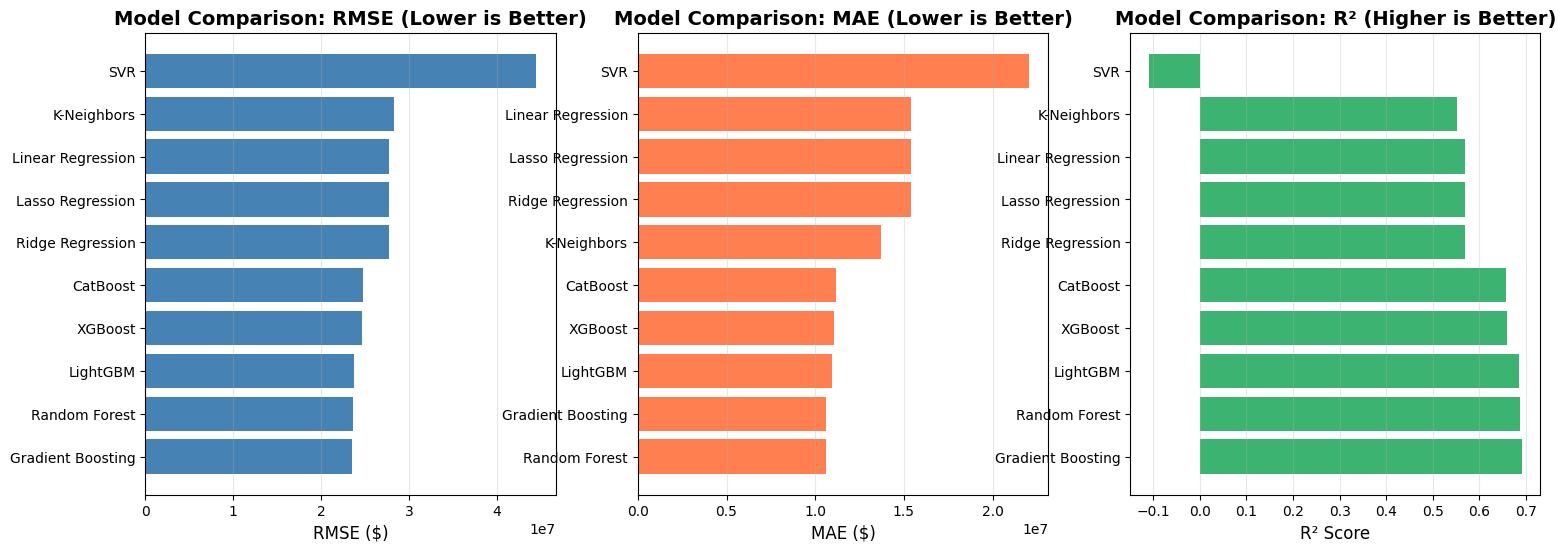

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE Comparison
sorted_df = comparison_df.sort_values('RMSE')
axes[0].barh(sorted_df['Model'], sorted_df['RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE ($)', fontsize=12)
axes[0].set_title('Model Comparison: RMSE (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# MAE Comparison
sorted_df = comparison_df.sort_values('MAE')
axes[1].barh(sorted_df['Model'], sorted_df['MAE'], color='coral')
axes[1].set_xlabel('MAE ($)', fontsize=12)
axes[1].set_title('Model Comparison: MAE (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# R² Comparison
sorted_df = comparison_df.sort_values('R²', ascending=False)
axes[2].barh(sorted_df['Model'], sorted_df['R²'], color='mediumseagreen')
axes[2].set_xlabel('R² Score', fontsize=12)
axes[2].set_title('Model Comparison: R² (Higher is Better)', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

It appears that Gradient Boosting Regressor yields the best results for my dataset. So let's move forward with it.

#Hyperparameter Tuning

I used TimeSeriesSplit instead of standard Cross-Validation (which shuffles data) because the latter would train on "future" movies to predict "past" ones. TimeSeriesSplit splits my training set into 5 progressive windows, ensuring zero leakage.

In [60]:
# 1. Define the Parameter Grid
# We search over a range of values for each hyperparameter
param_dist = {
    'n_estimators': randint(100, 500),        # Number of trees
    'learning_rate': uniform(0.01, 0.2),      # Step size (smaller is usually better but slower)
    'max_depth': randint(3, 8),               # Depth of each tree (control overfitting)
    'min_samples_split': randint(2, 20),      # Min samples to split a node
    'min_samples_leaf': randint(1, 10),       # Min samples in a leaf
    'subsample': uniform(0.7, 0.3),           # Fraction of samples per tree (stochastic gradient boosting)
    'max_features': ['sqrt', 'log2', None]    # Number of features to consider for best split
}

# 2. Setup Time-Series Cross-Validation
# This ensures we always train on past and validate on future within the training set
tscv = TimeSeriesSplit(n_splits=5)

# 3. Initialize the Model
gbr = GradientBoostingRegressor(random_state=42)

# 4. Setup Randomized Search
# n_iter=50 means it will try 50 random combinations. Increase for better results (but slower).
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error', # We want to minimize RMSE
    cv=tscv,                               # strict time-series splits
    verbose=1,
    random_state=42,
    n_jobs=-1                              # Use all available cores
)

# 5. Fit the Search
print("Starting Hyperparameter Tuning...")
random_search.fit(X_train, y_train)

# 6. Display Results
print("\n--- Tuning Complete ---")
print(f"Best RMSE (CV): {-random_search.best_score_:,.0f}")
print(f"Best Parameters: {random_search.best_params_}")

# 7. Evaluate the Best Model on the Held-Out Test Set
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n--- Final Test Set Evaluation ---")
print(f"Tuned Model RMSE: ${rmse_tuned:,.0f}")
print(f"Tuned Model R2:   {r2_tuned:.4f}")

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Tuning Complete ---
Best RMSE (CV): 19,813,807
Best Parameters: {'learning_rate': np.float64(0.01872075435088675), 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 198, 'subsample': np.float64(0.9243156321692241)}

--- Final Test Set Evaluation ---
Tuned Model RMSE: $23,553,147
Tuned Model R2:   0.6888


#Final Model

In [61]:
# 1. Initialize the model with your best parameters
best_gb = GradientBoostingRegressor(
    learning_rate=0.01872075435088675,
    max_depth=6,
    max_features='log2',
    min_samples_leaf=5,
    min_samples_split=7,
    n_estimators=198,
    subsample=0.9243156321692241,
    random_state=42
)

# 2. Train on the Training Set
print("Training tuned Gradient Boosting model...")
best_gb.fit(X_train, y_train)

# 3. Predict and Evaluate
y_pred_tuned = best_gb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2 = r2_score(y_test, y_pred_tuned)

print(f"Final Model RMSE: ${rmse:,.0f}")
print(f"Final Model R2:   {r2:.4f}")

Training tuned Gradient Boosting model...
Final Model RMSE: $23,553,147
Final Model R2:   0.6888


#Explainability (SHAP)

 SHAP (SHapley Additive exPlanations) is a game theory-based approach that helps to explain why a model made a specific prediction by showing the contribution of each feature to that prediction.

In [62]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_gb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
print(feature_importance.head(5).to_string(index=False))


Top 5 Most Important Features:
             feature  importance
            Theaters    0.237661
              Budget    0.167390
director_bankability    0.133806
        is_franchise    0.064917
Market_Share_Percent    0.064001


Theaters and Budget are the two strongest predictors of opening revenue, followed by the director's bankability.

In [63]:
# Ensure data is sorted by date for Time Series Split
df_sorted = df.sort_values('Release_Date')
X_sorted = df_sorted[feature_cols].fillna(0)
y_sorted = df_sorted['Opening_Week_Revenue']

# n_splits=5 creates 5 test windows moving forward in time
tscv = TimeSeriesSplit(n_splits=5)

scoring = {
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'r2': 'r2'
}

cv_results = cross_validate(best_gb, X_sorted, y_sorted, cv=tscv, scoring=scoring, n_jobs=-1)

# 6. Process Results (Convert negatives to positives)
mae_scores = -cv_results['test_mae']
mse_scores = -cv_results['test_mse']
r2_scores = cv_results['test_r2']
rmse_scores = np.sqrt(mse_scores)  # Adding RMSE for reference

# Results
results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'MAE': mae_scores,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'R2': r2_scores
})

print("\n--- Cross-Validation Results ---")
# Format for cleaner display (commas and decimals)
pd.set_option('display.float_format', '{:,.2f}'.format)
print(results_df)

print("\n--- Average Performance ---")
print(f"Mean MAE:  ${mae_scores.mean():,.2f}")
print(f"Mean MSE:  {mse_scores.mean():,.2e}")
print(f"Mean RMSE: ${rmse_scores.mean():,.2f}")
print(f"Mean R2:   {r2_scores.mean():.4f}")


--- Cross-Validation Results ---
   Fold           MAE                    MSE          RMSE   R2
0     1 10,892,463.66 341,018,988,314,377.69 18,466,699.44 0.73
1     2 10,956,245.30 491,310,847,193,142.75 22,165,532.87 0.73
2     3  9,927,995.69 351,065,451,167,852.69 18,736,740.68 0.79
3     4 14,242,128.49 726,937,640,712,260.88 26,961,781.11 0.70
4     5 11,986,099.22 785,829,991,962,641.00 28,032,659.38 0.59

--- Average Performance ---
Mean MAE:  $11,600,986.47
Mean MSE:  5.39e+14
Mean RMSE: $22,872,682.70
Mean R2:   0.7075


Based on R2 score, the model explains 70.75% of the variation in opening week revenue. On average, prediction is off by about $11.6 million.

Calculating SHAP values... (this might take a moment)


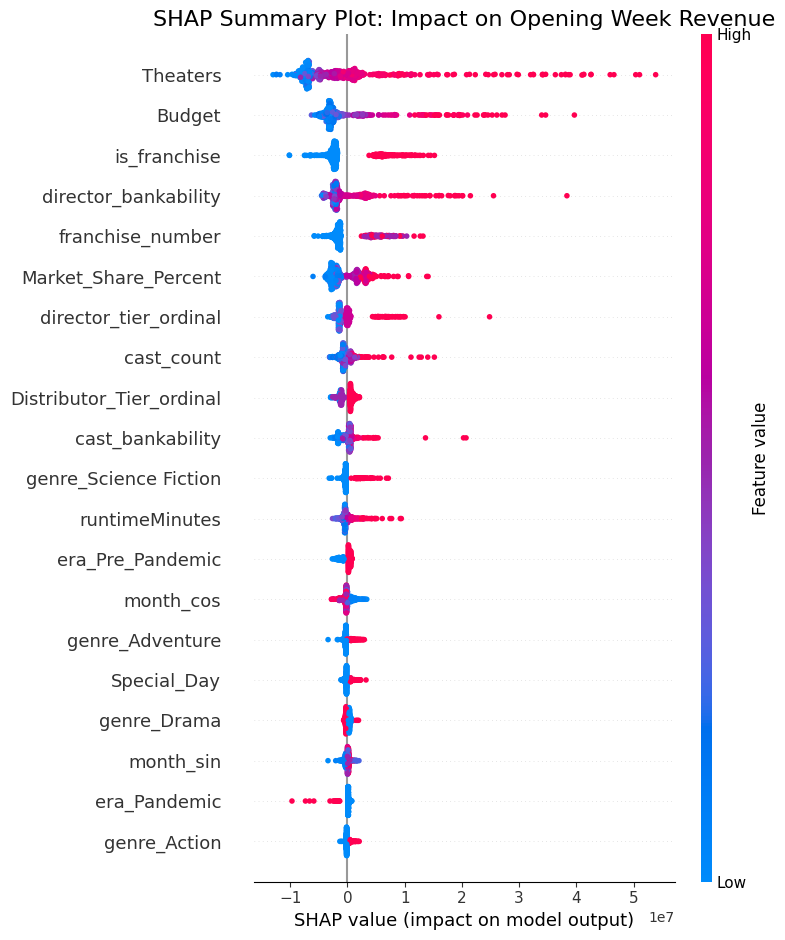

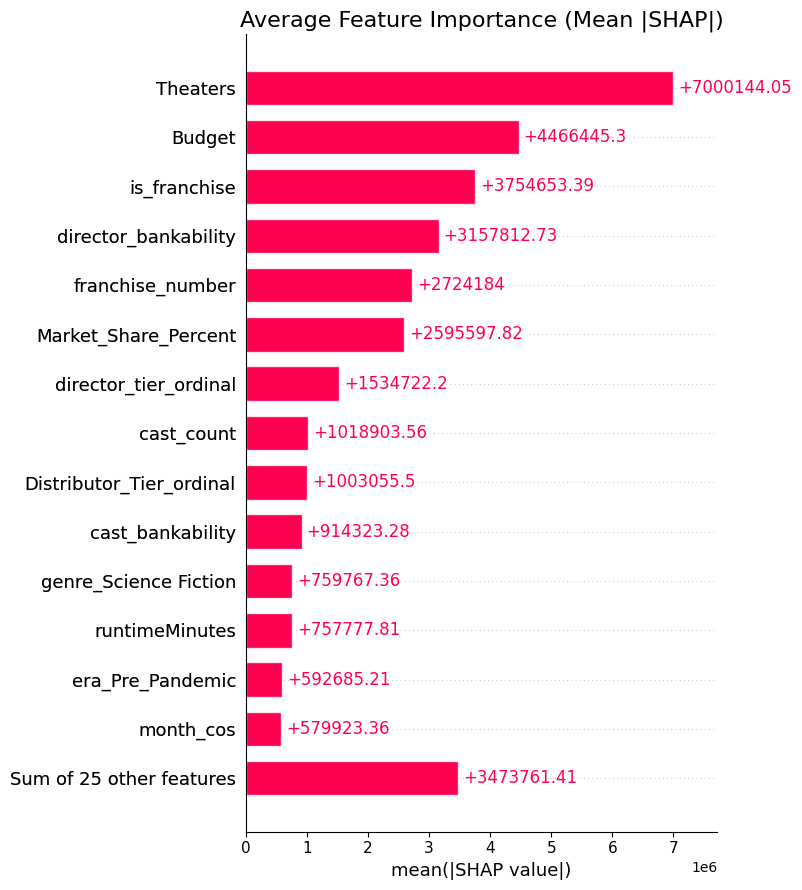

Generating dependence plot for Theaters...


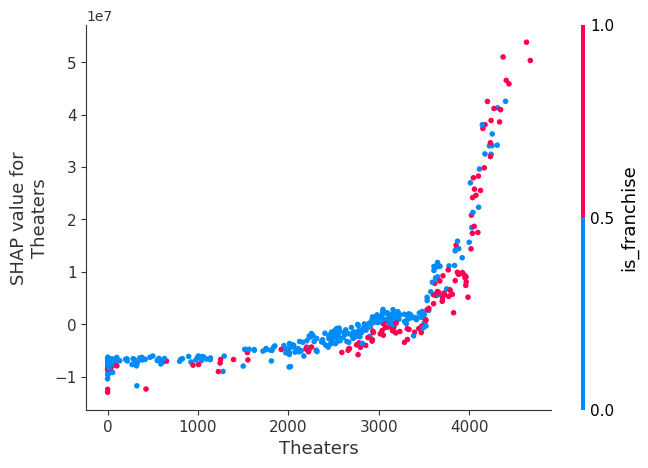

In [70]:
try:
      # 1. Setup the Model and Data
      model_to_explain = best_gb

      # SHAP calculates importance based on how much each feature pushes the prediction away from the "average" prediction.
      print("Calculating SHAP values... (this might take a moment)")
      # 2. Create the Explainer (Gradient Boosting is a tree-based model, so we use TreeExplainer)
      explainer = shap.TreeExplainer(model_to_explain)

      # 3. Calculate SHAP Values on the Test Set
      # We explain the test set to see how the model made decisions on unseen data.
      shap_values = explainer(X_test)

      # --- VISUALIZATIONS ---

      # Plot 1: Summary Plot (Beeswarm)
      # This is the single most useful plot.
      # - Y-axis: Features
      # - X-axis: SHAP value (impact on revenue). Positive = increases revenue, Negative = decreases.
      # - Color: Feature Value (Red = High, Blue = Low)
      plt.figure(figsize=(12, 10))
      plt.title("SHAP Summary Plot: Impact on Opening Week Revenue", fontsize=16)
      shap.summary_plot(shap_values, X_test, show=False)
      plt.tight_layout()
      plt.show()

      # Plot 2: Feature Importance Bar Plot
      # Shows the average absolute impact of each feature (magnitude only).
      plt.figure(figsize=(10, 8))
      plt.title("Average Feature Importance (Mean |SHAP|)", fontsize=16)
      shap.plots.bar(shap_values, max_display=15, show=False)
      plt.tight_layout()
      plt.show()

      # Plot 3: Dependence Plot (Interaction Effects)
      # Let's look at the #1 most important feature
      # This shows how the feature's value (x-axis) changes the impact (y-axis),
      # and how it interacts with another feature (color).
      top_feature = 'Theaters'
      print(f"Generating dependence plot for {top_feature}...")
      shap.dependence_plot(top_feature, shap_values.values, X_test, interaction_index='auto')

except Exception as e:
      # IF IT FAILS, JUST SKIP IT
      print(f"A SHAP Error occurred: {e}") # Modified to print the actual error 'e'
      print ("Likely due to mismatch in version type or other environment issue. You can run this on Colab if it's not already.")
      print("Moving on to next block (Skipping SHAP)...")

###Findings:

**The "Big Two" Dominate: Theaters & Budget**

Theaters: This is the strongest predictor. This means releasing a movie in many theaters (High Value) massively increases the revenue prediction (by up to \$50M+ in some cases). On average, just knowing the number of theaters shifts the prediction by ~$7,000,000.

Budget: Similarly to theaters, High budget (Red) correlates strongly with higher revenue predictions. Low budget (Blue) pulls the prediction down. The budget shifts the prediction by ~$4.4M.

#Creating _Avatar: Fire and Ash_ Prediction Dataset

First, I gather factual information from credible online sources and educated guess.

In [71]:
# Known information
avatar_info = {
    'Theaters': 4300, #Avatar opened in 3452 theaters back in 2009,
    #Avatar 2 opened in 4202 theaters (nearly 1000 more from Avatar 1) despite screening freshly after pandemic;
    #for Avatar 3, 4300 is a safe bet
    'Release_Date': '2025-12-19',
    'runtimeMinutes': 195,
    'Special_Day': 1, #Releasing one week before Christmas Day
    'Budget': 400000000,
    'Distributor': '20th Century Studios',
    'directors': 'nm0000116',  # James Cameron
    'mpaa_rating': 'PG-13',
    'genres': 'Action,Adventure,Science Fiction', #main genres, same as Avatar 2
    'is_franchise': 1,
    'franchise_number': 3,
    'cast_count': 64, # from TMDb
    'actors': ['Sam Worthington', 'Zoe Saldaña']
}

I then initialize the known information from `avatar_info` in my final DataFrame `avatar_pred`.

In [72]:
avatar_info['Release_Date'] = pd.to_datetime(avatar_info['Release_Date'])

avatar_pred = pd.DataFrame({
    'Theaters': [avatar_info['Theaters']],
    'runtimeMinutes': [avatar_info['runtimeMinutes']],
    'Special_Day': [avatar_info['Special_Day']],
    'Budget': [avatar_info['Budget']],
    'cast_count': [avatar_info['cast_count']],
    'is_franchise': [avatar_info['is_franchise']],
    'franchise_number': [avatar_info['franchise_number']]
})

Now, I proceed to calculate the `cast_bankability` for the Avatar movie by processing the `top_actors` and their historical performance, filling in cold start scenarios using distributor median revenue.



In [73]:
avatar_top_actors_list = avatar_info['actors']

avatar_actor_scores = []
for actor_name in avatar_top_actors_list:
    # Find the actor's score from df_actors, based on movies released *before* the Avatar movie
    actor_history = df_actors[(df_actors['actor'] == actor_name) & (df_actors['Release_Date'] < avatar_info['Release_Date'])]

    if not actor_history.empty:
        # Use the most recent actor_score from their history
        actor_score = actor_history['actor_score'].iloc[-1]
    else:
        # If no history for the actor, use the distributor's median revenue (cold start)
        actor_score = distributor_medians.get(avatar_info['Distributor'], 0) # Default to 0 if distributor not found

    avatar_actor_scores.append(actor_score)

# Calculate cast_bankability as the mean of the lead actors' scores
if avatar_actor_scores:
    avatar_pred['cast_bankability'] = np.mean(avatar_actor_scores)
else:
    avatar_pred['cast_bankability'] = 0 # Default if no actors or scores found

print("Calculated cast bankability for Avatar movie.")

Calculated cast bankability for Avatar movie.


I will now encode the distributor information for the Avatar movie's prediction by extracting its market share percentage and mapping its distributor tier to an ordinal value. This uses pre-calculated `dist_market_stats` and `distributor_map` from earlier steps.



In [74]:
distributor_name = avatar_info['Distributor']
avatar_dist_stats = dist_market_stats[dist_market_stats['Distributor'] == distributor_name]

if not avatar_dist_stats.empty:
    avatar_pred['Market_Share_Percent'] = avatar_dist_stats['Market_Share_Percent'].iloc[0]
    avatar_pred['Distributor_Tier_ordinal'] = distributor_map.get(avatar_dist_stats['Distributor_Tier'].iloc[0], 0)
else:
    avatar_pred['Market_Share_Percent'] = 0
    avatar_pred['Distributor_Tier_ordinal'] = distributor_map.get('Small', 0)

print("Encoded distributor information for Avatar movie.")

Encoded distributor information for Avatar movie.


Next, I encode the director's bankability score and map their tier to an ordinal value, adding these features to the `avatar_pred` DataFrame. This leverages the pre-computed `bankability_mapping`, `tier_mapping`, and `director_map` from earlier feature engineering steps.



In [75]:
director_id = avatar_info['directors']

avatar_pred['director_bankability'] = bankability_mapping.get(director_id, 0) # Default to 0
avatar_pred['director_tier_ordinal'] = director_map.get(tier_mapping.get(director_id, 'Debut'), 0) # Default to 'Debut'

print("Encoded director bankability for Avatar movie.")

Encoded director bankability for Avatar movie.


I will now apply one-hot encoding for the genres of the Avatar movie. This involves parsing the genre string into a list and then using the pre-fitted `MultiLabelBinarizer` (`mlb`) to create new binary columns in `avatar_pred` for each genre, ensuring all `feature_cols` genres are present.



In [76]:
def parse_genres(genre_string):
    if pd.isna(genre_string):
        return []
    genres = [g.strip() for g in str(genre_string).split(',')]
    genres = [g for g in genres if g]
    return genres

avatar_genre_list = parse_genres(avatar_info['genres'])
avatar_genre_encoded = mlb.transform([avatar_genre_list])
avatar_genre_df = pd.DataFrame(avatar_genre_encoded, columns=mlb.classes_).add_prefix('genre_')

for col in [f for f in feature_cols if f.startswith('genre_')]:
    if col in avatar_genre_df.columns:
        avatar_pred[col] = avatar_genre_df[col].iloc[0]
    else:
        avatar_pred[col] = 0

print("Applied genre one-hot encoding for Avatar movie.")

Applied genre one-hot encoding for Avatar movie.


I will now apply the release era binning logic to the Avatar movie's release date and one-hot encode the resulting era. This ensures consistency with the training data's era features and prepares these binary columns for prediction.



In [77]:
avatar_era = get_release_era(avatar_info['Release_Date'])

avatar_pred['era_Pandemic'] = int(avatar_era == 'Pandemic')
avatar_pred['era_Post_Pandemic'] = int(avatar_era == 'Post_Pandemic')
avatar_pred['era_Pre_Pandemic'] = int(avatar_era == 'Pre_Pandemic')

print("Applied release era binning and one-hot encoding for Avatar movie.")

Applied release era binning and one-hot encoding for Avatar movie.


Now that the release era has been correctly one-hot encoded, I will apply cyclical encoding to the month and day of the week derived from the `Release_Date` to capture their periodic nature, adding these features to the `avatar_pred` DataFrame.



In [78]:
release_month_num = avatar_info['Release_Date'].month
release_day_of_week_num = avatar_info['Release_Date'].dayofweek # Monday=0, Sunday=6

avatar_pred['month_sin'] = np.sin(2 * np.pi * release_month_num / 12)
avatar_pred['month_cos'] = np.cos(2 * np.pi * release_month_num / 12)
avatar_pred['day_sin'] = np.sin(2 * np.pi * release_day_of_week_num / 7)
avatar_pred['day_cos'] = np.cos(2 * np.pi * release_day_of_week_num / 7)

print("Applied cyclical encoding for month and day to Avatar movie prediction.")

Applied cyclical encoding for month and day to Avatar movie prediction.


I will now apply ordinal encoding to the MPAA rating of the Avatar movie, mapping it to a numerical value based on its strictness. This ensures consistency with the training data's ordinal `mpaa_rating` feature and prepares it for prediction.



In [79]:
avatar_pred['mpaa_rating_ordinal'] = rating_map.get(avatar_info['mpaa_rating'], rating_map.get('NR', 0))

print("Applied MPAA rating ordinal encoding for Avatar movie.")

Applied MPAA rating ordinal encoding for Avatar movie.


##Fitting Avatar data to feature columns

The next step is to ensure the `avatar_pred` DataFrame contains all the required feature columns in the correct order, filling any missing ones with zeros, so it matches the structure of the training data (`X`) used by the model.



In [80]:
for col in feature_cols:
    if col not in avatar_pred.columns:
        avatar_pred[col] = 0

avatar_pred = avatar_pred[feature_cols]
avatar_pred = avatar_pred.fillna(0) # Final check for any remaining NaNs

print("Finalized Avatar prediction DataFrame with all feature columns.")

Finalized Avatar prediction DataFrame with all feature columns.


##**Predicting revenue for Avatar: Fire and Ash**

Now that the `avatar_pred` DataFrame is fully prepared with all the engineered features and aligned with the model's expected input, I will use the `best_gb` (Gradient Boosting Regressor) model to predict the Opening Week Revenue for the Avatar movie. This completes the subtask of preparing the data and getting a prediction.



In [81]:
predicted_revenue = best_gb.predict(avatar_pred)

print(f"Predicted Opening Week Revenue for Avatar movie: ${predicted_revenue[0]:,.2f}")

Predicted Opening Week Revenue for Avatar movie: $225,141,318.20


In [82]:
display(avatar_pred)

,Theaters,runtimeMinutes,Special_Day,Budget,cast_count,Market_Share_Percent,director_bankability,era_Pandemic,era_Post_Pandemic,era_Pre_Pandemic,...,is_franchise,franchise_number,month_sin,month_cos,day_sin,day_cos,mpaa_rating_ordinal,cast_bankability,director_tier_ordinal,Distributor_Tier_ordinal
0,4300,195,1,400000000,64,10.11,90.42,0,1,0,...,1,3,-0.00,1.00,-0.43,-0.90,3,"60,826,690.00",4,2


##Summary

###The predicted opening week revenue for the Avatar movie is **\$225,141,318.20**.

### Data Analysis Key Findings
*   The `avatar_pred` DataFrame was successfully prepared by incorporating various features:
    *   Direct attributes: `Theaters`, `runtimeMinutes`, `Special_Day`, `Budget`, `cast_count`, `is_franchise`, and `franchise_number`.
    *   Derived metrics for cast and crew: `cast_bankability` (calculated from lead actors' historical scores or distributor median for new actors), `director_bankability`, and `director_tier_ordinal`.
    *   Distributor insights: `Market_Share_Percent` and `Distributor_Tier_ordinal`.
    *   Genre encoding: Genres were one-hot encoded using a `MultiLabelBinarizer`.
    *   Temporal features: Release era (`Pre_Pandemic`, `Pandemic`, `Post_Pandemic`) was one-hot encoded, and cyclical features (`month_sin`, `month_cos`, `day_sin`, `day_cos`) were added for the release date.
    *   MPAA rating: Ordinally encoded into `mpaa_rating_ordinal`.

*   The final `avatar_pred` DataFrame was aligned with the `feature_cols` used by the model, ensuring all required columns were present (with missing ones filled with 0) and in the correct order.
*   The pre-trained Gradient Boosting model (`best_gb`) successfully predicted the opening week revenue for the Avatar movie as \$225,141,318.20.




### Insights or Next Steps
*   This comprehensive feature engineering approach, combining movie-specific data with historical performance metrics for talent and distributors, significantly enriches the dataset for more accurate revenue predictions.
*   To enhance model interpretability, an analysis of feature importance from the `best_gb` model could be performed to understand which factors most heavily influence opening week revenue predictions.